In [1]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/")

from ast import literal_eval
import collections
import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import mean, stdev
from scipy.stats import pearsonr

In [2]:
def read_ind_plot(group_name, group_1, group_2, eval_metric, ax, xaxis):
    """ 
    Read the pairwise dataframe and plot the relationship between xaxis (horizontal feature) and eval_metric (vertical feature) \
    on axies ax, returns the pearson coefficient between xais and yaxis
    :param str xaxis: xaxis can be label_div_score, w_term or source_{eval_metric}
    """
    score_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_OT.csv")
    score_df = pd.read_csv(score_path, header=0, index_col=None)
    eval_metric = eval_metric.lower()
    xaxis = xaxis.lower()

    ax.set_ylim(0, 2*1e6)
    y_feature = score_df[f'trans_target_{eval_metric}']
    if xaxis == 'label_div_score':
        x_feature = score_df['label_div_score']
        ax.scatter(x_feature, y_feature, s=3)
        ax.set_xlim(0, 2*1e8)
    elif xaxis == 'w_term':
        x_feature = np.multiply(score_df['max_h'], (score_df['wa_dist'] + np.multiply(score_df['diameter'], score_df['coupling_diff'])))
        ax.scatter(x_feature, y_feature, s=3)
        ax.set_xlim(0, 0.4)
    return pearsonr(x_feature, y_feature)
    


In [3]:
# Combine score into one plot
def read_entire_plot(group_name, groups, xaxis, eval_metric):
    """ 
    Read the entire dataframe and plot the relationship between xaxis (horizontal feature) and eval_metric (vertical feature) \
    on axies ax, returns the pearson coefficient between xais and yaxis
    :param str xaxis: xaxis can be label_div_score, w_term or source_{eval_metric}
    """
    x_features = []
    y_features = []
    plt.figure(figsize=(7, 5))
    for group_1 in groups:
        for group_2 in groups:
            if group_1 == group_2:
                continue
            score_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_OT.csv")
            score_df = pd.read_csv(score_path, header=0, index_col=None)
            eval_metric = eval_metric.lower()
            xaxis = xaxis.lower()

            y_feature = score_df[f'trans_target_{eval_metric}']
            if xaxis == 'label_div_score':
                x_feature = score_df['label_div_score']
            elif xaxis == 'w_term':
                x_feature = np.multiply(score_df['max_h'], (score_df['wa_dist'] + np.multiply(score_df['diameter'], score_df['coupling_diff'])))
            x_features.extend(x_feature)
            y_features.extend(y_feature)
    if xaxis == 'label_div_score':
        plt.xlim(0, 2*1e8)
        plt.xlabel("labeling divergence score", fontsize=20)
    elif xaxis == 'w_term':
        plt.xlim(0, 0.4)
        plt.xlabel("Wasserstein distance & \n degree of unbalancedness", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.scatter(x_features, y_features, s=3)
    fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{xaxis}_entire_bound.pdf")
    plt.ylabel("target error", fontsize=20)
    plt.tight_layout()
    plt.savefig(fig_path, bbox_inches='tight')
    corr, _ = pearsonr(x_features, y_features)
    
    return corr

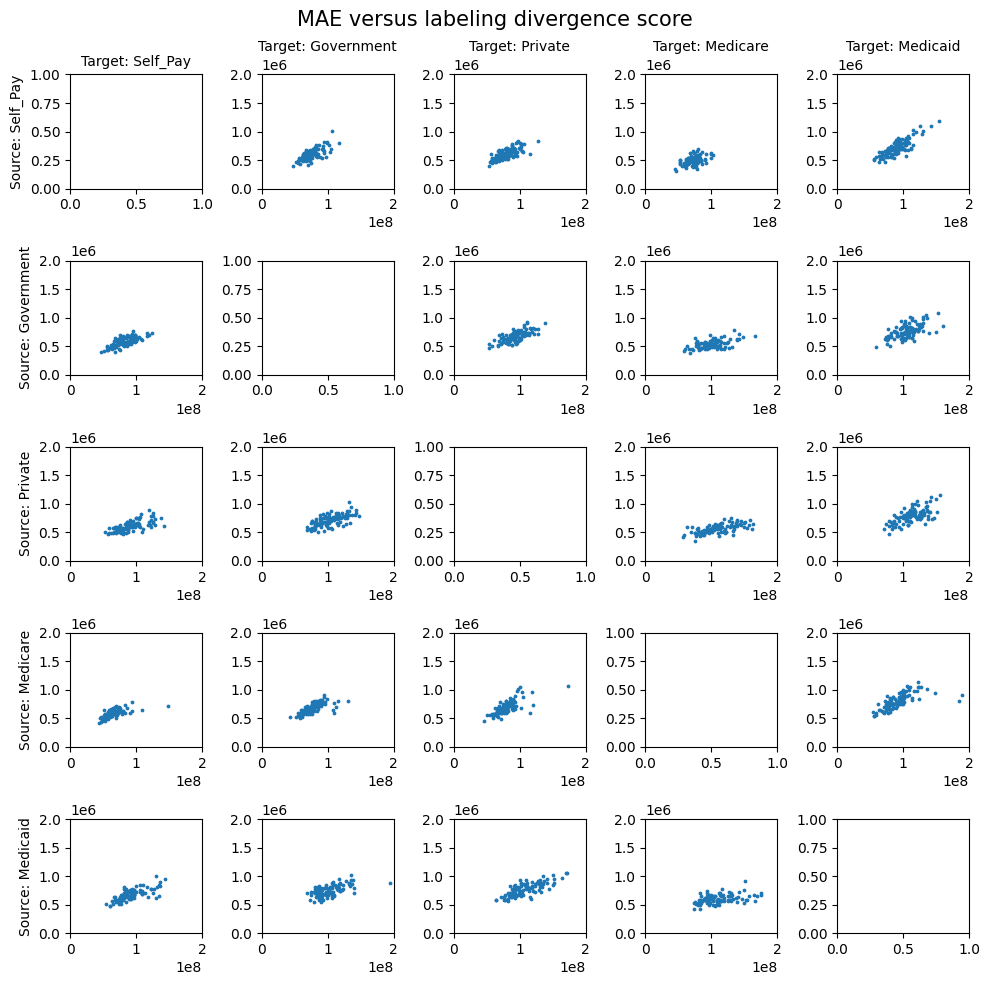

average pearson coefficient is: 0.6627916259780353


In [4]:
group_name = 'insurance'
groups = ['Self_Pay', 'Government', 'Private',  'Medicare', 'Medicaid']

# group_name = 'marital_status'
# groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

eval_metric = 'MAE'
fig, axs = plt.subplots(len(groups), len(groups))
fig.set_figwidth(10)
fig.set_figheight(10)
xaxis = "label_div_score"
avg_corr = 0

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if j == 0:
            axs[i, j].set_ylabel(f'Source: {group_1}', fontsize=10)
        if i == 0:
            axs[i, j].set_title(f'Target: {group_2}', fontsize=10)
        if group_1 == group_2:
            # axs[i, j].axis('off')
            continue

        corr, _ = read_ind_plot(group_name, group_1, group_2, eval_metric, axs[i, j], xaxis)
        avg_corr += corr
fig.suptitle(f"{eval_metric} versus labeling divergence score", fontsize=15)
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{xaxis}_bound.pdf")
plt.savefig(fig_path)
plt.show()
print("average pearson coefficient is:", avg_corr/(len(groups)*(len(groups)-1)))


pearson correlation coefficient is: 0.5556993646329762


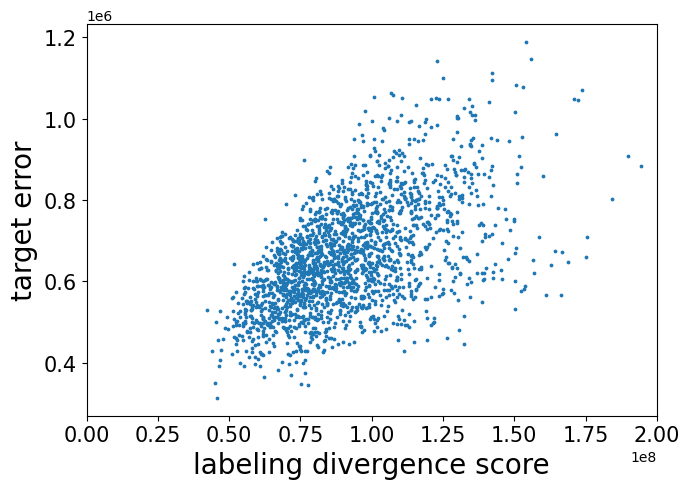

In [5]:
corr = read_entire_plot(group_name, groups, xaxis, eval_metric)
print("pearson correlation coefficient is:", corr)

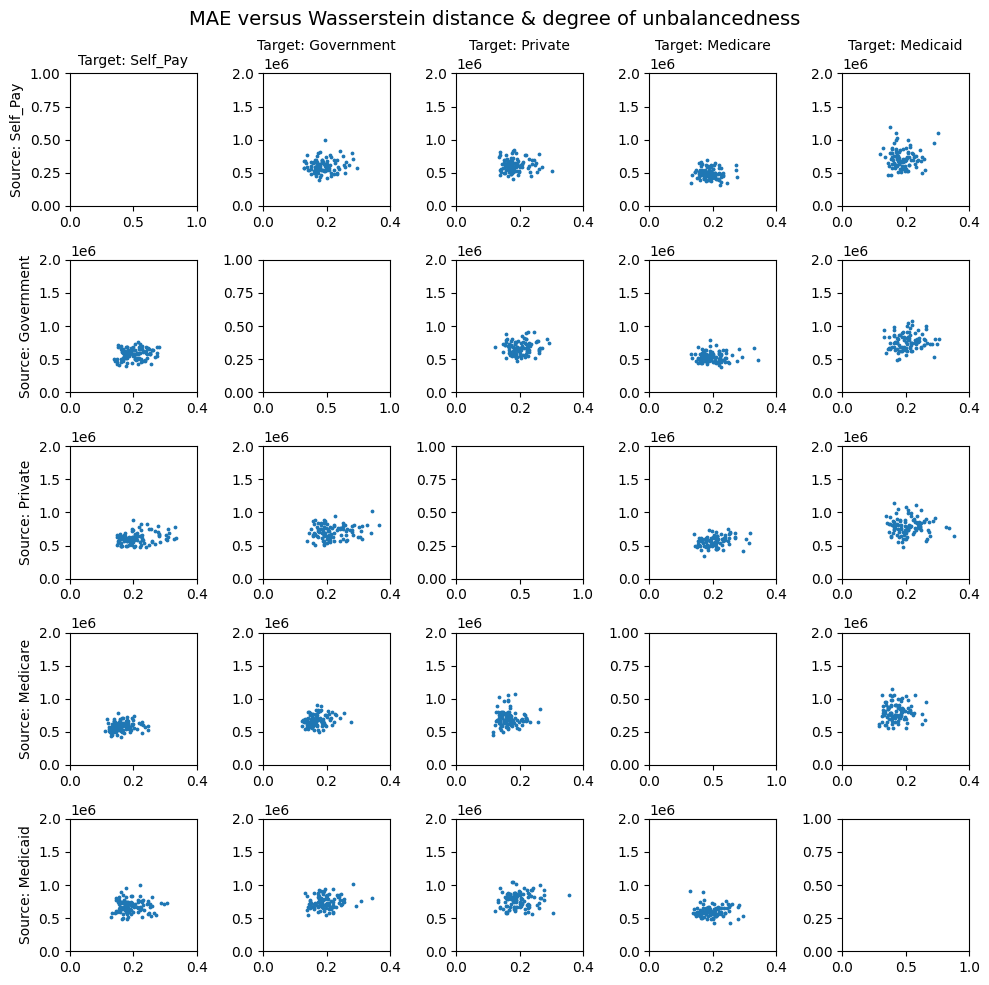

average pearson coefficient is: 0.10161155345457548


In [6]:
fig, axs = plt.subplots(len(groups), len(groups))
fig.set_figwidth(10)
fig.set_figheight(10)
xaxis = "w_term"
avg_corr = 0

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if j == 0:
            axs[i, j].set_ylabel(f'Source: {group_1}', fontsize=10)
        if i == 0:
            axs[i, j].set_title(f'Target: {group_2}', fontsize=10)
        if group_1 == group_2:
            continue

        corr, _ = read_ind_plot(group_name, group_1, group_2, eval_metric, axs[i, j], xaxis)
        avg_corr += corr
fig.suptitle(f"{eval_metric} versus Wasserstein distance & degree of unbalancedness", fontsize=14)
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{xaxis}_bound.pdf")
plt.savefig(fig_path)
plt.show()
print("average pearson coefficient is:", avg_corr/(len(groups)*(len(groups)-1)))


pearson correlation coefficient is: 0.07118070883746364


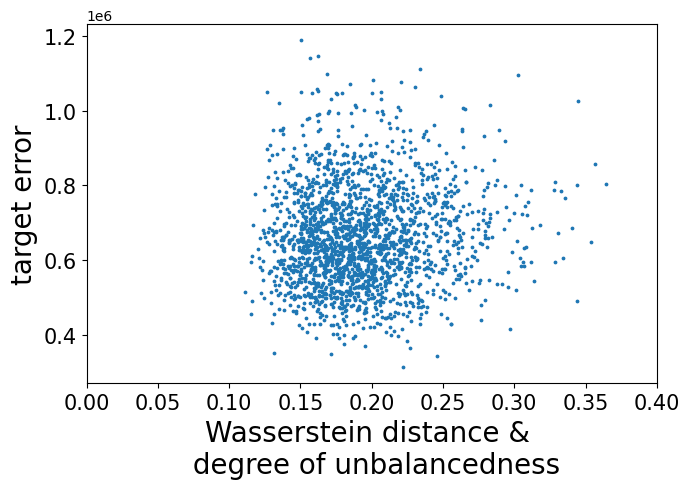

In [7]:
corr = read_entire_plot(group_name, groups, xaxis, eval_metric)
print("pearson correlation coefficient is:", corr)

In [8]:
# Combine score into one plot, for the 4 plots 
def read_entire_plot(group_name, groups, xaxis, eval_metric):
    """ 
    Read the entire dataframe and plot the relationship between xaxis (horizontal feature) and eval_metric (vertical feature) \
    on axies ax, returns the pearson coefficient between xais and yaxis
    :param str xaxis: xaxis can be label_div_score, w_term or source_{eval_metric}
    """
    group_names = ['insurance', 'marital_status']
    groups = [['Self_Pay', 'Government', 'Private',  'Medicare', 'Medicaid'], ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']]

    x_features = []
    y_features = []
    for group_1 in groups:
        for group_2 in groups:
            if group_1 == group_2:
                continue
            score_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_OT.csv")
            score_df = pd.read_csv(score_path, header=0, index_col=None)
            eval_metric = eval_metric.lower()
            xaxis = xaxis.lower()

            y_feature = score_df[f'trans_target_{eval_metric}']
            if xaxis == 'label_div_score':
                x_feature = score_df['label_div_score']
            elif xaxis == 'w_term':
                x_feature = np.multiply(score_df['max_h'], (score_df['wa_dist'] + np.multiply(score_df['diameter'], score_df['coupling_diff'])))
            x_features.extend(x_feature)
            y_features.extend(y_feature)
    if xaxis == 'label_div_score':
        plt.xlim(0, 2*1e8)
        plt.xlabel("labeling divergence score", fontsize=20)
    elif xaxis == 'w_term':
        plt.xlim(0, 0.4)
        plt.xlabel("Wasserstein distance & \n degree of unbalancedness", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.scatter(x_features, y_features, s=3)
    fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{xaxis}_entire_bound.pdf")
    plt.ylabel("target error", fontsize=20)
    plt.savefig(fig_path)
    corr, _ = pearsonr(x_features, y_features)
    
    return corr